<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/pytorch_2_dim_moon_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torch import nn
from sklearn import datasets
from torch.utils.data import DataLoader

In [2]:
class Datasets(torch.utils.data.Dataset):
    def __init__(self, sample_size=1000):
        super(Datasets, self).__init__()

        self.uniform = torch.distributions.Uniform(low=torch.tensor([0., 0.]), high=torch.tensor([1., 1.]))
        self.x_uniform = self.uniform .sample([sample_size])

        self.length = sample_size

    def __len__(self):
            return self.length

    def __getitem__(self, idx):
        x = self.x_uniform[idx, :]
        return x

In [3]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim))


    def forward(self, x):
        return self.f(x)

    def coupling_layer(self, x, m, forward=True):

        x_a = x[:, 0].reshape((-1,1))
        x_b = x[:, 1].reshape((-1,1))

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        z = torch.concat((x_a, y_b), axis=1)

        return z


    def f(self, x):
        z = x

        for model in self.m:
            z = self.coupling_layer(z, model, forward=True)

        z = z * torch.exp(-self.s)
        log_det_j = torch.sum(self.s)      # eksi olabilir başında

        return z, log_det_j

    def f_inv(self, z):
        x = z * torch.exp(self.s)

        for model in reversed(self.m):
            x = self.coupling_layer(x, model, forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) - log_det_j).sum()
        else:

            loss = - (prior.log_prob(z).sum(dim=1) - log_det_j).mean()
        return loss

In [4]:
#x = Datasets(sample_size=1000)
prior = torch.distributions.Normal(loc=torch.tensor([0., 0.]), scale=torch.tensor([1., 1.]))

model = NICE(input_dim=2, hidden_layer=512, num_flows=20)


In [5]:
X,y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.01, random_state=1234)
x = torch.tensor(X, dtype=torch.float32)

train_loader = DataLoader(x, batch_size=100)

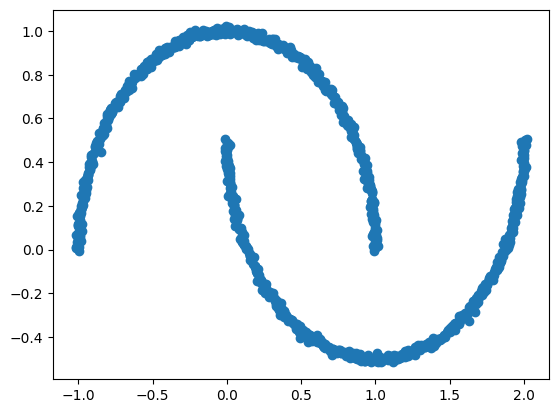

In [6]:
plt.scatter(x[:][:,0], x[:][:,1])

In [7]:
epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%100 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  5.179507493972778
Epoch :  100   -----------> Loss :  2.1224602699279784
Epoch :  200   -----------> Loss :  1.8187108635902405
Epoch :  300   -----------> Loss :  1.775016176700592
Epoch :  400   -----------> Loss :  1.7714788675308228
Epoch :  500   -----------> Loss :  1.7714409232139587


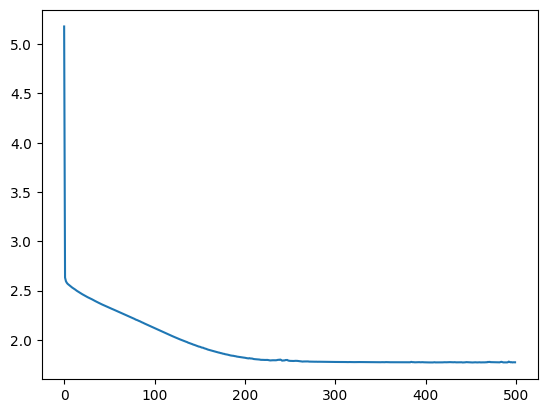

In [8]:
plt.plot(COST)

In [9]:
test = prior.sample((1000,))
test

tensor([[ 0.1049, -0.7954],
        [ 1.3404,  0.5889],
        [ 1.0938, -1.5070],
        ...,
        [ 0.0456, -1.7937],
        [ 0.2972,  1.9236],
        [-0.5805,  0.2650]])

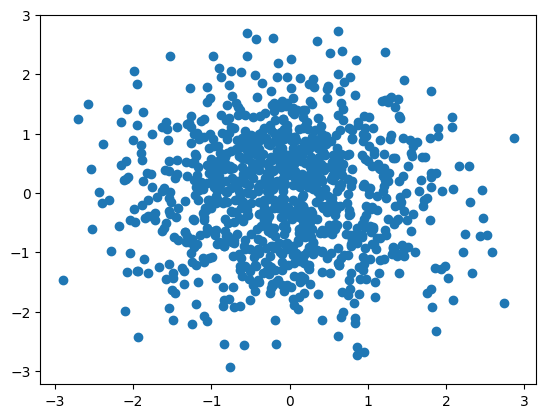

In [10]:
plt.scatter(test[:,0], test[:,1])

In [11]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 0.1050,  0.0644],
        [ 1.3411, -0.2338],
        [ 1.0944, -1.0068],
        ...,
        [ 0.0457, -0.2440],
        [ 0.2973,  0.9405],
        [-0.5808,  0.8927]], grad_fn=<CatBackward0>)

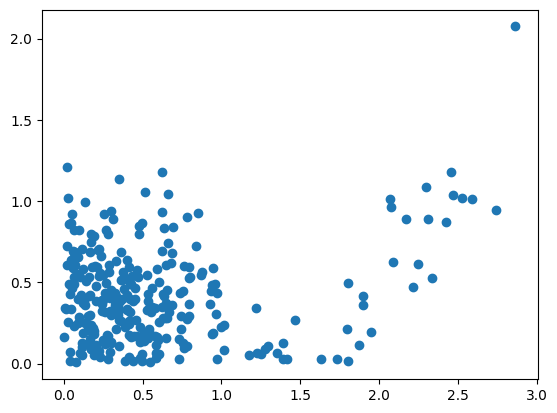

In [12]:
a = sonuc.detach().numpy()[sonuc.detach().numpy()[:,0]>0]
b = a[a[:,1]>0]
plt.scatter(b[:,0], b[:,1])

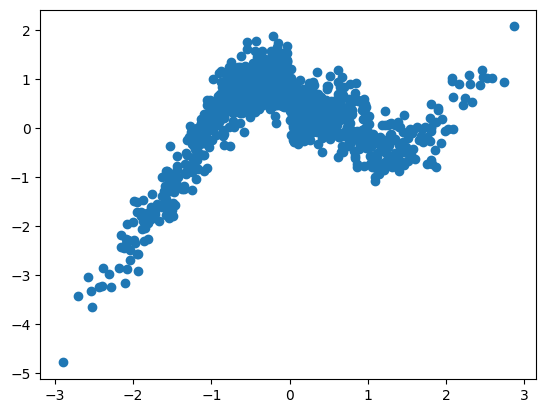

In [13]:
plt.scatter(sonuc[:,0].detach().numpy(), sonuc[:,1].detach().numpy())